In [1]:
cd ..

/Users/crupley/DS/projects/kaggle/prudential


In [149]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.decomposition import NMF
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV


import xgboost as xgb

# load data

In [58]:
train = pd.read_csv('data/train.csv')
y = train.pop('Response')
split = train.shape[0]
print train.shape
print y.shape

(59381, 127)
(59381,)


In [59]:
test = pd.read_csv('data/test.csv')
print test.shape

(19765, 127)


In [60]:
df = pd.concat((train, test))
df.set_index('Id', inplace=True)
df.shape

(79146, 126)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79146 entries, 2 to 79129
Columns: 126 entries, Product_Info_1 to Medical_Keyword_48
dtypes: float64(18), int64(107), object(1)
memory usage: 76.7+ MB


# clean

In [62]:
# categorical
ccol = 'Product_Info_1, Product_Info_2, Product_Info_3, Product_Info_5, Product_Info_6, Product_Info_7, Employment_Info_2, Employment_Info_3, Employment_Info_5, InsuredInfo_1, InsuredInfo_2, InsuredInfo_3, InsuredInfo_4, InsuredInfo_5, InsuredInfo_6, InsuredInfo_7, Insurance_History_1, Insurance_History_2, Insurance_History_3, Insurance_History_4, Insurance_History_7, Insurance_History_8, Insurance_History_9, Family_Hist_1, Medical_History_2, Medical_History_3, Medical_History_4, Medical_History_5, Medical_History_6, Medical_History_7, Medical_History_8, Medical_History_9, Medical_History_11, Medical_History_12, Medical_History_13, Medical_History_14, Medical_History_16, Medical_History_17, Medical_History_18, Medical_History_19, Medical_History_20, Medical_History_21, Medical_History_22, Medical_History_23, Medical_History_25, Medical_History_26, Medical_History_27, Medical_History_28, Medical_History_29, Medical_History_30, Medical_History_31, Medical_History_33, Medical_History_34, Medical_History_35, Medical_History_36, Medical_History_37, Medical_History_38, Medical_History_39, Medical_History_40, Medical_History_41'.split(', ')
print len(ccol)
ccol[:5]

60


['Product_Info_1',
 'Product_Info_2',
 'Product_Info_3',
 'Product_Info_5',
 'Product_Info_6']

In [63]:
df = pd.get_dummies(df, dummy_na=True, columns=ccol)
print df.shape

(79146, 1012)


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79146 entries, 2 to 79129
Columns: 1012 entries, Product_Info_4 to Medical_History_41_nan
dtypes: float64(964), int64(48)
memory usage: 611.7 MB


In [144]:
trainX = df[:split]
trainX = trainX.fillna(trainX.mean(axis=0))
testX = df[split:]
testX = testX.fillna(trainX.mean(axis=0))
print trainX.shape
print testX.shape

(59381, 1012)
(19765, 1012)


In [177]:
empties = df[:split].isnull().sum().sort_values(ascending=False)
empties

Medical_History_10         58824
Medical_History_32         58274
Medical_History_24         55580
Medical_History_15         44596
Family_Hist_5              41811
Family_Hist_3              34241
Family_Hist_2              28656
Insurance_History_5        25396
Family_Hist_4              19184
Employment_Info_6          10854
Medical_History_1           8889
Employment_Info_4           6779
Employment_Info_1             19
Medical_History_2_101.0        0
Medical_History_2_99.0         0
Medical_History_2_98.0         0
Medical_History_2_97.0         0
Medical_History_2_96.0         0
Medical_History_2_95.0         0
Medical_History_2_100.0        0
Medical_History_41_nan         0
Medical_History_2_102.0        0
Medical_History_2_93.0         0
Medical_History_2_103.0        0
Medical_History_2_104.0        0
Medical_History_2_105.0        0
Medical_History_2_106.0        0
Medical_History_2_94.0         0
Medical_History_2_86.0         0
Medical_History_2_92.0         0
          

1012

# train model

## random forest

In [184]:
%%time
rf = RandomForestClassifier(n_jobs=-1, oob_score=True, n_estimators=200, min_samples_leaf=5)
rf.fit(trainX[empties.index[10:]], y)
print rf.oob_score_

0.508832791634
CPU times: user 2min 37s, sys: 7.13 s, total: 2min 44s
Wall time: 1min 31s


In [179]:
cv = cross_val_score(rf, trainX[empties.index[10:]], y)
print cv
print np.mean(cv)
print np.std(cv) * 1000

[ 0.50979996  0.49944428  0.50482543]
0.50468988711
4.22877629664


In [185]:
fi = pd.DataFrame({'feature':trainX[empties.index[10:]].columns, 'importance':rf.feature_importances_})
fisort = fi.sort_values('importance', ascending=False)
fisort

,feature,importance
337,BMI,0.131454
338,Wt,0.094163
1001,Product_Info_4,0.049470
535,Medical_History_4_2.0,0.044420
536,Medical_History_4_1.0,0.038462
721,Medical_History_23_3.0,0.037326
723,Medical_History_23_1.0,0.036187
340,Ins_Age,0.035475
322,Medical_Keyword_15,0.027095
339,Ht,0.020765


In [162]:
trainX[fisort.feature.values[:100]].head(15)

,BMI,Wt,Product_Info_4,Ins_Age,Employment_Info_1,Medical_History_15,Ht,Employment_Info_6,Medical_History_1,Family_Hist_4,...,Medical_History_2_335.0,Employment_Info_5_2.0,Employment_Info_3_3.0,Medical_History_2_16.0,Employment_Info_5_3.0,Employment_Info_2_1.0,Medical_History_8_3.0,Medical_History_2_161.0,Product_Info_3_26.0,Medical_History_30_3.0
Id,,,,,,,,,,,,,,,,,,,,,
2,0.323008,0.148536,0.076923,0.641791,0.028,240.000000,0.581818,0.361469,4.000000,0.444890,...,0,0,0,0,1,0,0,0,0,0
5,0.272288,0.131799,0.076923,0.059701,0.000,0.000000,0.600000,0.001800,5.000000,0.084507,...,0,1,1,0,0,1,0,0,1,0
6,0.428780,0.288703,0.076923,0.029851,0.030,123.760974,0.745455,0.030000,10.000000,0.225352,...,0,1,0,0,0,0,0,0,1,0
7,0.352438,0.205021,0.487179,0.164179,0.042,123.760974,0.672727,0.200000,0.000000,0.352113,...,0,0,0,0,1,0,0,0,0,0
8,0.424046,0.234310,0.230769,0.417910,0.027,123.760974,0.654545,0.050000,7.962172,0.408451,...,0,1,0,0,0,0,0,0,1,0
10,0.364887,0.299163,0.230769,0.507463,0.325,123.760974,0.836364,1.000000,6.000000,0.507042,...,0,1,0,0,0,0,0,0,1,0
11,0.376587,0.173640,0.166194,0.373134,0.110,123.760974,0.581818,0.800000,5.000000,0.549296,...,0,0,1,0,1,1,0,0,0,0
14,0.571612,0.403766,0.076923,0.611940,0.120,123.760974,0.781818,1.000000,6.000000,0.444890,...,0,1,0,0,0,0,0,0,1,0
15,0.362643,0.184100,0.230769,0.522388,0.165,123.760974,0.618182,1.000000,4.000000,0.676056,...,0,1,0,1,0,0,0,0,1,0


In [163]:
trainX[fisort.feature.values[:10]].describe()

,BMI,Wt,Product_Info_4,Ins_Age,Employment_Info_1,Medical_History_15,Ht,Employment_Info_6,Medical_History_1,Family_Hist_4
count,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000
mean,0.469462,0.292587,0.328952,0.405567,0.077582,123.760974,0.707283,0.361469,7.962172,0.444890
std,0.122213,0.089037,0.282562,0.197190,0.082334,49.156795,0.074239,0.315993,12.013085,0.134119
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.385517,0.225941,0.076923,0.238806,0.035000,123.760974,0.654545,0.100000,2.000000,0.380282
50%,0.451349,0.288703,0.230769,0.402985,0.060000,123.760974,0.709091,0.350000,5.000000,0.444890
75%,0.532858,0.345188,0.487179,0.567164,0.100000,123.760974,0.763636,0.500000,8.000000,0.492958
max,1.000000,1.000000,1.000000,1.000000,1.000000,240.000000,1.000000,1.000000,240.000000,0.943662


In [70]:
np.cumsum(fi['importance'].sort_values(ascending=False)).values

array([ 0.06302805,  0.11565726,  0.14619024, ...,  1.        ,
        1.        ,  1.        ])

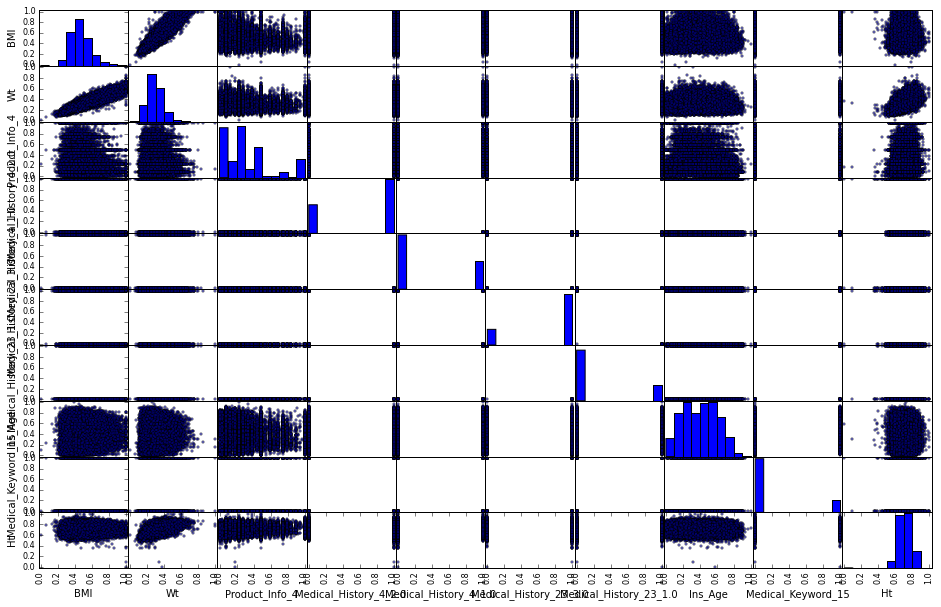

In [186]:
pd.scatter_matrix(trainX[fisort.feature.values[:10]], figsize=(16, 10))
plt.show()

In [169]:
trainX.dropna().shape

(59381, 1012)

# g boost tree

In [86]:
xg = xgb.XGBClassifier(n_estimators=25)
xg.fit(trainX, y)

XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=25,
       nthread=-1, objective='multi:softprob', seed=0, silent=True,
       subsample=1)

In [117]:
fsubset = fisort.feature.values[:]

In [101]:
%%time
cv = cross_val_score(xg, trainX[fsubset], y)
print cv
print np.mean(cv)
print np.std(cv) * 1000

[ 0.54682764  0.54349803  0.54292355]
0.544416407588
1.72105486442
CPU times: user 1min 20s, sys: 1.75 s, total: 1min 21s
Wall time: 1min 22s


In [118]:
params = {'n_estimators' : [10, 25, 100]}
gs = GridSearchCV(xg, params)
gs.fit(trainX, y)
print gs.best_params_
print gs.best_score_
gs.grid_scores_

{'n_estimators': 100}
0.56883514929


[mean: 0.52965, std: 0.00312, params: {'n_estimators': 10},
 mean: 0.54499, std: 0.00170, params: {'n_estimators': 25},
 mean: 0.56884, std: 0.00150, params: {'n_estimators': 100}]

In [145]:
xg = xgb.XGBClassifier(n_estimators=25, subsample=0.5, colsample_bytree=0.5)

In [146]:
%%time
cv = cross_val_score(xg, trainX[empties], y)
print cv
print np.mean(cv)
print np.std(cv) * 1000

[ 0.55435442  0.54956047  0.54514678]
0.549687223932
3.76006801214
CPU times: user 1min 14s, sys: 3.64 s, total: 1min 18s
Wall time: 1min 20s


In [127]:
xg = xgb.XGBClassifier(n_estimators=200, subsample=0.5, colsample_bytree=0.5)

In [128]:
%%time
cv = cross_val_score(xg, trainX, y)
print cv
print np.mean(cv)
print np.std(cv) * 1000

[ 0.58400687  0.58169142  0.57849528]
0.581397855783
2.25965395812
CPU times: user 8min 31s, sys: 8.61 s, total: 8min 39s
Wall time: 8min 52s


In [188]:
xg = xgb.XGBClassifier(n_estimators=1000, subsample=0.5, colsample_bytree=0.5)

In [135]:
%%time
cv = cross_val_score(xg, trainX, y)
print cv
print np.mean(cv)
print np.std(cv) * 1000

[ 0.59410992  0.58775386  0.58460917]
0.588824317262
3.9518341481
CPU times: user 42min 7s, sys: 25.1 s, total: 42min 32s
Wall time: 43min 30s


## adaboost

In [155]:
ab = AdaBoostClassifier(n_estimators=50)

In [153]:
%%time
cv = cross_val_score(ab, trainX, y)
print cv
print np.mean(cv)
print np.std(cv) * 1000

[ 0.51106284  0.49626149  0.51503209]
0.507452139884
8.0771963763
CPU times: user 44.4 s, sys: 3.59 s, total: 48 s
Wall time: 49.1 s


In [157]:
%%time
params = {'learning_rate' : np.logspace(-3, 0, 4),
          'n_estimators' : [10, 25, 50]}
gs = GridSearchCV(ab, params)
gs.fit(trainX, y)
print gs.best_params_
print gs.best_score_
gs.grid_scores_

{'n_estimators': 50, 'learning_rate': 1.0}
0.507451878547
CPU times: user 6min 1s, sys: 37.5 s, total: 6min 38s
Wall time: 7min


In [158]:
gs.grid_scores_

[mean: 0.39839, std: 0.00182, params: {'n_estimators': 10, 'learning_rate': 0.001},
 mean: 0.39839, std: 0.00182, params: {'n_estimators': 25, 'learning_rate': 0.001},
 mean: 0.39796, std: 0.00133, params: {'n_estimators': 50, 'learning_rate': 0.001},
 mean: 0.39796, std: 0.00133, params: {'n_estimators': 10, 'learning_rate': 0.01},
 mean: 0.39819, std: 0.00164, params: {'n_estimators': 25, 'learning_rate': 0.01},
 mean: 0.40558, std: 0.00452, params: {'n_estimators': 50, 'learning_rate': 0.01},
 mean: 0.41956, std: 0.00207, params: {'n_estimators': 10, 'learning_rate': 0.10000000000000001},
 mean: 0.43874, std: 0.00085, params: {'n_estimators': 25, 'learning_rate': 0.10000000000000001},
 mean: 0.46951, std: 0.00885, params: {'n_estimators': 50, 'learning_rate': 0.10000000000000001},
 mean: 0.48889, std: 0.00557, params: {'n_estimators': 10, 'learning_rate': 1.0},
 mean: 0.49797, std: 0.00628, params: {'n_estimators': 25, 'learning_rate': 1.0},
 mean: 0.50745, std: 0.00808, params: {'n

In [155]:
ab = AdaBoostClassifier(n_estimators=50)

In [153]:
%%time
cv = cross_val_score(ab, trainX, y)
print cv
print np.mean(cv)
print np.std(cv) * 1000

[ 0.51106284  0.49626149  0.51503209]
0.507452139884
8.0771963763
CPU times: user 44.4 s, sys: 3.59 s, total: 48 s
Wall time: 49.1 s


# naive bayes

In [106]:
nb = MultinomialNB()

In [107]:
%%time
cv = cross_val_score(nb, trainX, y)
print cv
print np.mean(cv)
print np.std(cv) * 1000

[ 0.39907052  0.40214206  0.39987873]
0.400363771769
1.3000109482
CPU times: user 3.19 s, sys: 3.35 s, total: 6.54 s
Wall time: 7.25 s


In [116]:
params = {'alpha' : np.logspace(-2, 2, 5)}
gs = GridSearchCV(nb, params)
gs.fit(trainX, y)
print gs.best_params_
print gs.best_score_
gs.grid_scores_

[mean: 0.39720, std: 0.00096, params: {'alpha': 0.01}, mean: 0.39775, std: 0.00078, params: {'alpha': 0.10000000000000001}, mean: 0.40036, std: 0.00130, params: {'alpha': 1.0}, mean: 0.41439, std: 0.00252, params: {'alpha': 10.0}, mean: 0.38591, std: 0.00096, params: {'alpha': 100.0}]
{'alpha': 10.0}
0.414391808828


# make submission

In [ ]:
xg.fit(trainX, y)
yhat = xg.predict(testX)
result = pd.DataFrame({'Id' : testX.index.values, 'Response': yhat})
result.to_csv('results/out.csv', index=False)

## log

* initial: xgb
    * cv: 0.5345
    * submission: 0.45091
* fillna with mean, xgb
    * cv: 0.5450
* top features, xgb
    * 100: cv: 0.5436
    * 200: cv: 0.5444
* xgb: 100, subsample, colsample
    * cv: 0.5711
    * submission: 0.53671
* xgb: 200
    * cv: 0.58139
    * submission: 0.56030
* xgb: 1000
    * cv: 0.5888
    * submission:
* fix impute with train mean on both; xgb25
    * baseline: 0.5497
    * cv: 0.5497